Queremos usar la simulación por MonteCarlo para estimar la $\mathbb{P}_{e}$. Para esto necesitamos escribir esta probabilidad como una esperanza:

$$
\mathbb{P}_{e} = \mathbb{P}\left[\hat{X}_{1} \neq X_{1} \right] = \mathbb{E}\Big[\mathbb{1}\left[\hat{X}_{1} \neq X_{1}\right] \Big]
$$

donde $\mathbb{1}\left[.\right]$ es la función indicadora que devuelve $1$ ó $0$.

Tenemos que generar $k$ ensayos para luego usar alguna de las leyes de los grandes números (LGN). Entonces generamos $k$ realizaciones de la VA $X_{1}$: $x_{1}^{(1)}, \dots, x_{1}^{(k)}$ que son iid y van a tomar valores $A$ o $-A$. Para cada una de estas realizaciones generamos $n$ realizaciones de los ruidos: $w_{1}^{i}, \dots, w_{n}^{i}$, donde $n$ es la cantidad de repetidores. Luego con esto implementamos los repetidores. Para los $k$ conjuntos de realizaciones obtenemos $\hat{x}_{1}^{(i)}$:

$$
\left.\begin{array}{l}
x_{1}^{(1)},w_{1}^{(1)},\dots,w_{n}^{(1)} \rightarrow \hat{x}_{1}^{(1)}\\
\vdots\\
x_{1}^{(k)},w_{1}^{(k)},\dots,w_{n}^{(k)} \rightarrow \hat{x}_{1}^{(k)}
\end{array}\right\} \Rightarrow \frac{1}{k} \sum_{i=1}^{k} \mathbb{1}\Big[\hat{x}_{1}^{i} \neq x_{1}^{i} \Big]  \xrightarrow[k \to \infty]{LGN} \mathbb{P}_{e}
$$

Esto lo van a tener que repetir para cada valor de la SNR. Dado un valor de SNR y fijando un valor de $h$ y $A$ pueden obtener el valor de $\sigma^2$ para el ruido.

In [150]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm 
from math import sqrt, log10
import random

In [151]:
%matplotlib inline

#### Definicion de variables

In [152]:
A, h, n = 5, 0.9, 9
soporte_x1 = [-A, A]
k = 10000 # Cantidad de muetras 

$ SNR_1 = 10 \log_{10} ( \frac{h^2A^2}{\sigma^2})$ [dB]

In [153]:
def SNR_a_sigma(SNR):
    return sqrt( h**2 * A** 2 / SNR )

In [154]:
def SNR_a_G(SNR):
    return 1/h * sqrt(SNR/(SNR+1))

In [155]:
def generador_muestras(k):
    # Genera las muestras x_1 ^ 1,..., x_1 ^ k 
    return np.array([random.choice(soporte_x1) for _ in range(k)])

In [156]:
def generar_ruidos(k, n, SNR):
    #Genero los n=9 ruidos para cada una de las k muestras
    sigma = SNR_a_sigma(SNR)
    return np.array([np.random.normal(0, sigma, k) for _ in range(n)]) #Esta es de n x k

#### Simulo el analogico

In [157]:
def repetidor_digital(SNR, x1):
    ruidos = generar_ruidos(k,n,SNR)
    
    x_act = x1
    for i in range(n):
        #Agrego atenuacion y ruido
        y_act = h*x_act+ruidos[i]
        
        #Tomo la decision i-esima
        x_act = np.array([A if y>=0 else -A for y in y_act])      
       
    return x_act
    

In [158]:
y_n_analog = [] #Estas dos sirven para plotear cosas en el ultimo inciso
x_1_analog = []

def repetidor_analogico(SNR, x1):
    ruidos = generar_ruidos(k,n,SNR)
    x_1_analog.append(x1)
    G = SNR_a_G(SNR)
    x_act = x1
    for i in range(n-1):
        #Agrego atenuacion y ruido
        x_act = G*(h*x_act+ruidos[i])
    
    x_act = h*x_act+ruidos[n-1]
    y_n_analog.append(x_act)
    #Unico bloque D se encuentra al final 
    return np.array([A if x>=0 else -A for x in x_act])
    

In [159]:
SNRs4 = [i for i in range(5,26)]
Pe_digital = []
Pe_analog = []

for i in SNRs4:
    snr_decimal = 10**(i/10)
    x1 = generador_muestras(k)
    x1_final_digital = repetidor_digital(snr_decimal, x1)
    Pe_digital.append(sum([x1[i] != x1_final_digital[i] for i in range(k)])/k)
    
    x1_final_analog = repetidor_analogico(snr_decimal,x1)
    Pe_analog.append(sum([x1[i] != x1_final_analog[i] for i in range(k)])/k)

### Grafico las simulaciones junto con las probabilidades de error ideales

In [160]:
p_err_digital = lambda snr, n: (1-(1-2*norm.sf(sqrt(snr)))**n)/2  

def p_err_analog(snr, n): #Calculo sacado del ejercicio 2
    sigma = SNR_a_sigma(snr)
    G = SNR_a_G(snr)
    suma = 0
    for i in range(1,n+1):
        suma += ((h*G)**(n-i))**2
    var_Z = sigma**2 * suma
    aux = h**n * A * G**(n-1) / sqrt(var_Z)
    
    return norm.sf(aux)

p_err_digital = np.vectorize(p_err_digital)
p_err_analog = np.vectorize(p_err_analog)

#### Me armo los rangos del eje x

In [161]:
# rango [-5,30] con paso 1
SNRs_dB = np.linspace(-5,30, num=36)

In [162]:
# SNRs en escala lineal
SNRs = 10**((SNRs_dB)/10)

In [163]:
# Distintos Ns, cada 4
Ns = np.arange(1, 26, 4)

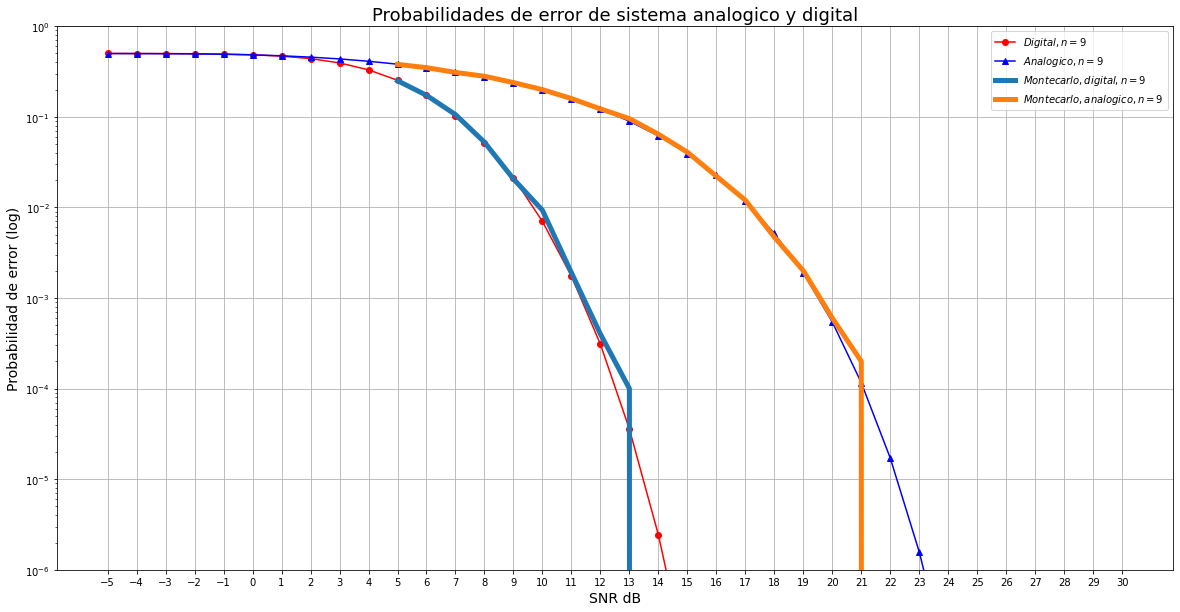

In [164]:
plt.figure(figsize=(20,10))

### Colors

digital_colors = iter((plt.get_cmap('autumn'))(np.linspace(0,1,len(Ns))))
analog_colors = iter((plt.get_cmap('winter'))(np.linspace(0,1,len(Ns))))

plt.plot(SNRs_dB, p_err_digital(SNRs, 9), 'o-', color=next(digital_colors), label='$Digital, n={}$'.format(9))    
plt.plot(SNRs_dB, p_err_analog(SNRs, 9), '^-', color=next(analog_colors), label='$Analogico, n={}$'.format(9))

plt.plot(SNRs4, Pe_digital, linewidth=5, label='$Monte carlo, digital, n=9$')
plt.plot(SNRs4, Pe_analog, linewidth=5, label='$Monte carlo, analogico, n=9$')
    
plt.xticks(SNRs_dB)
plt.ylim(ymin=10**-6)
plt.ylim(ymax=10**0)
plt.yscale('log')
plt.legend(loc='best')
plt.xlabel("SNR dB", fontsize = 14)
plt.ylabel("Probabilidad de error (log)", fontsize = 14)
plt.title("Probabilidades de error de sistema analogico y digital", fontsize = 18)
plt.grid()
plt.savefig("Grafico 4_1 log.png")

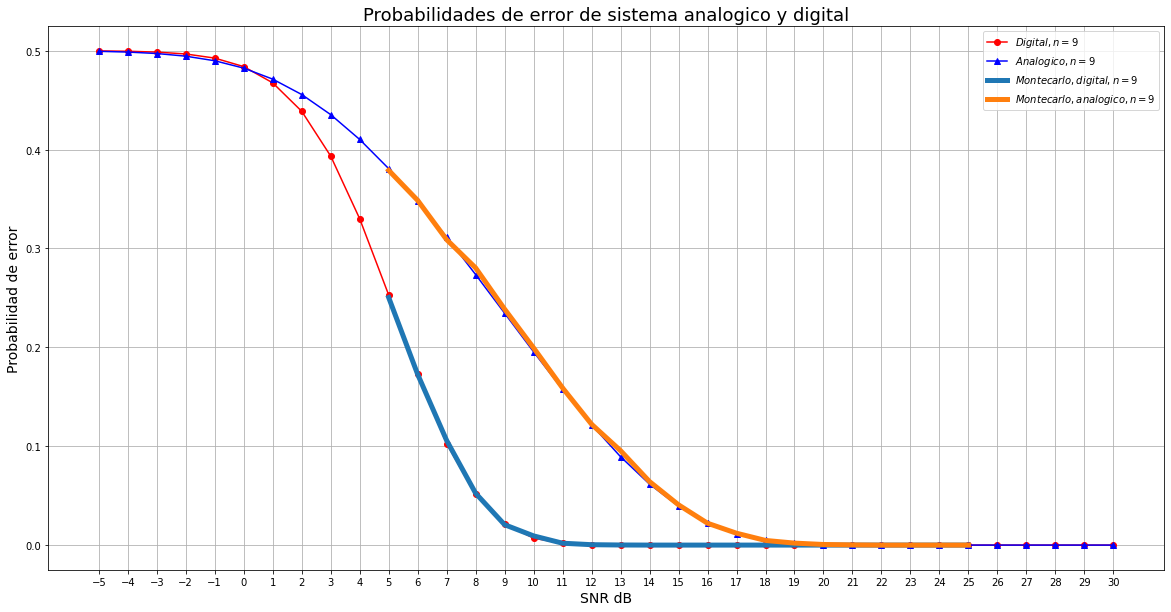

In [165]:
plt.figure(figsize=(20,10))

### Colors

digital_colors = iter((plt.get_cmap('autumn'))(np.linspace(0,1,len(Ns))))
analog_colors = iter((plt.get_cmap('winter'))(np.linspace(0,1,len(Ns))))

plt.plot(SNRs_dB, p_err_digital(SNRs, 9), 'o-', color=next(digital_colors), label='$Digital, n={}$'.format(9))    
plt.plot(SNRs_dB, p_err_analog(SNRs, 9), '^-', color=next(analog_colors), label='$Analogico, n={}$'.format(9))

plt.plot(SNRs4, Pe_digital, linewidth=5, label='$Monte carlo, digital, n=9$')
plt.plot(SNRs4, Pe_analog, linewidth=5, label='$Monte carlo, analogico, n=9$')
    
plt.xticks(SNRs_dB)
plt.legend(loc='best')
plt.xlabel("SNR dB", fontsize = 14)
plt.ylabel("Probabilidad de error", fontsize = 14)
plt.title("Probabilidades de error de sistema analogico y digital", fontsize = 18)
plt.grid()
plt.savefig("Grafico 4_1 lineal.png")

### Ejercicio 4.3

 Notemos que:
 $$Y_{n}=X_{1}h^{n}\prod_{i=2}^{n}G_{i}+\sum_{i=1}^{n}\left( h^{n-i}W_{i} \prod_{j=i+1}^{n}G_{j}\right)$$
 
 La misma representa una variable con distribucion normal, de media $X_{1}h^{n}\prod_{i=2}^{n}G_{i}$ y varianza $ V[\sum_{i=1}^{n}\left( h^{n-i}W_{i} \prod_{j=i+1}^{n}G_{j}\right)]$
 
 El calculo de la varianza es analogo al que se realizo en el error ideal del repetidor analogico

In [166]:
def pdf_Yn(snr, X1):
    G = SNR_a_G(snr)
    suma = 0
    for i in range(1,n+1):
        suma += (h*G)**(n-i)
    var_Z = SNR_a_sigma(snr)**2 * suma
    mu_Z = h**n * X1 * G**(n-1)
    return mu_Z, sqrt(var_Z)

In [269]:
def graficos_pdfs_y_sim(snr):
    mu_Z, sigma_Z = pdf_Yn(snr, A)
    mu_Z_neg, sigma_Z_neg = pdf_Yn(snr, -A)
    y_n_analog_pos, y_n_analog_neg = [], []
    for i in range(len(x1)):
        if x_1_analog[snr-5][i]>0:
            y_n_analog_pos.append(y_n_analog[snr-5][i])
        else:
            y_n_analog_neg.append(y_n_analog[snr-5][i])
            
    x = np.linspace(-20,20,10000)
    y = norm.pdf(x,mu_Z,sigma_Z)
    y1 = norm.pdf(x,mu_Z_neg,sigma_Z_neg)
    plt.figure(figsize = (14,5))
    plt.subplot(1, 2, 1)
    plt.plot(x,y,label = "pdf de $Y_{n | X_1 = A}$")
    N, bins, patches = plt.hist(y_n_analog_pos, bins = 100, density = True)

    for i in range(len(patches)):
        if(bins[i]<0):
            patches[i].set_color('r')
        else:
            patches[i].set_color('g')
        
    
    plt.legend()
    plt.grid()
    plt.ylabel('probabilidad de $Y_n$')
    plt.suptitle("$SNR$ = {}".format(snr), fontsize =  15)
    plt.subplot(1, 2, 2)
    plt.plot(x,y1, label = "pdf de $Y_{n | X_1 = -A}$")
    N, bins, patches = plt.hist(y_n_analog_neg,  bins = 100, density = True)
    
    for i in range(len(patches)):
        if(bins[i]>=0):
            patches[i].set_color('r')
        else:
            patches[i].set_color('g')
        
    
    plt.grid()
    plt.legend()
    plt.savefig("Grafico 4_3_SNR={}".format(snr))
    plt.show()

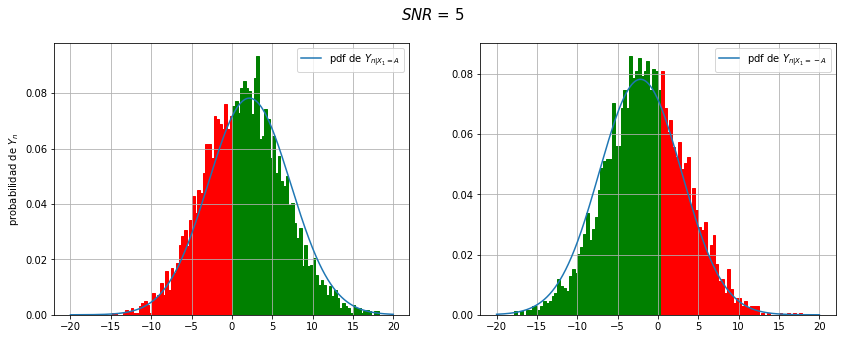

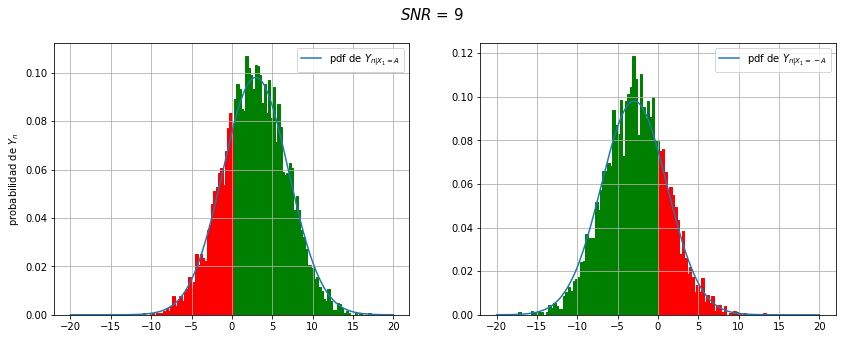

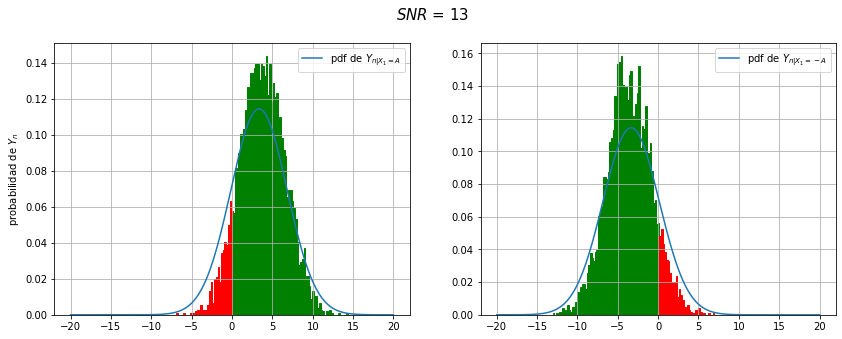

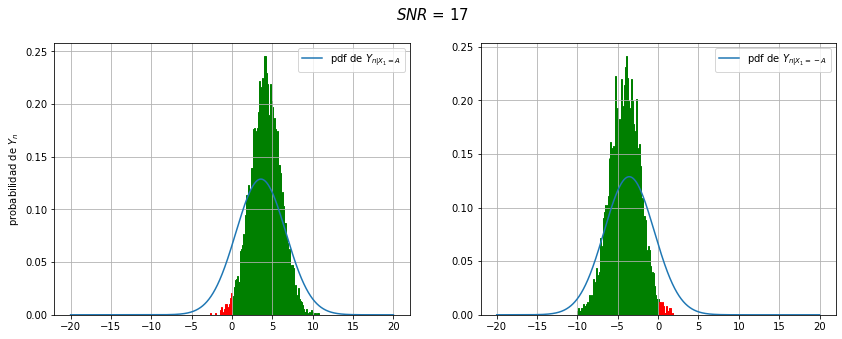

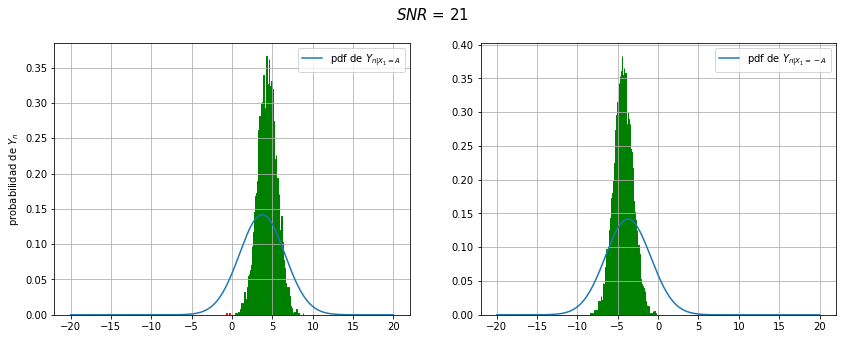

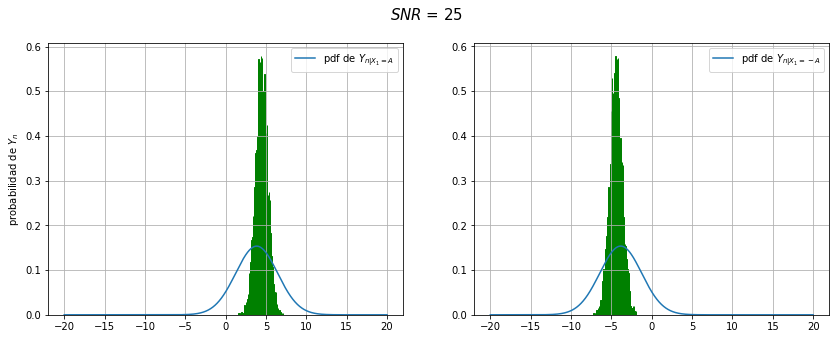

In [270]:
for snr in range(5,26,4):
    graficos_pdfs_y_sim(snr)